In [1]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import cv2

#data path 수정
os.chdir("C:\\Users\\Owner2\\Desktop\\G팔로미_vuno")
os.getcwd()

'C:\\Users\\Owner2\\Desktop\\G팔로미_vuno'

In [2]:
X=np.load('data_X.npy')
y=np.load('data_y.npy')

In [3]:
#train, validation set 분리
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.3)

In [4]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    #featurewise_center=True, #center 중심 유지
    #featurewise_std_normalization=True, #normalization
    rotation_range=25.0,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #brightness_range=[0.2,1.0],
    horizontal_flip=True) #수평방향 뒤집기

datagen.fit(X_train)

dgf=datagen.flow(X_train,y_train,batch_size=32)

Using TensorFlow backend.


In [11]:
from keras import models, layers
from keras import Input
from keras.applications import ResNet50
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, initializers, regularizers, metrics
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization, Conv2D, Activation, Dense, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Add

model = ResNet50(weights=None, include_top=False, input_shape=(224, 224, 3))
model.trainable = True
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

C:\Users\Owner2\Anaconda3\envs\keras2\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [12]:
#customizing my layers
additional_model = models.Sequential()
additional_model.add(model)
additional_model.add(layers.Flatten())
additional_model.add(layers.Dense(4, activation='softmax'))

additional_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_2 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 401412    
Total params: 23,989,124
Trainable params: 23,936,004
Non-trainable params: 53,120
_________________________________________________________________


In [13]:
def f1score(precision, recall):
    _f1score = ( 2 * recall * precision) / (recall + precision)
    
    # return a single tensor value
    return _f1score

In [14]:
# checkpoint = ModelCheckpoint(filepath='My_VGG_{epoch:03d}_{val_loss:.7f}.hdf5',monitor='loss', mode='min', save_best_only=True)
checkpoint = ModelCheckpoint(filepath='ResNet_1.hdf5', 
            monitor='loss', 
            mode='min', 
            save_best_only=True)

In [15]:
import tensorflow as tf

additional_model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.Adam(lr=2e-5),
              metrics=['acc',tf.keras.metrics.AUC(),
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(), f1score])

In [16]:
history = additional_model.fit_generator(dgf, 
            steps_per_epoch=150, 
            epochs=40, 
            validation_data=(X_val,y_val), 
            validation_steps=32, 
            callbacks=[checkpoint])

Epoch 1/40
150/150 [==============================] - 62s 411ms/step - loss: 1.6446 - acc: 0.4103 - auc_1: 0.6322 - precision_1: 0.3826 - recall_1: 0.2927 - f1score: 0.1197 - val_loss: 1.7347 - val_acc: 0.3108 - val_auc_1: 0.6717 - val_precision_1: 0.4371 - val_recall_1: 0.3327 - val_f1score: 0.0983
Epoch 2/40
150/150 [==============================] - 49s 326ms/step - loss: 1.4769 - acc: 0.4701 - auc_1: 0.6832 - precision_1: 0.4486 - recall_1: 0.3460 - f1score: 0.1313 - val_loss: 1.5988 - val_acc: 0.3201 - val_auc_1: 0.6953 - val_precision_1: 0.4594 - val_recall_1: 0.3552 - val_f1score: 0.1034
Epoch 3/40
150/150 [==============================] - 49s 326ms/step - loss: 1.4182 - acc: 0.4683 - auc_1: 0.7024 - precision_1: 0.4638 - recall_1: 0.3602 - f1score: 0.1346 - val_loss: 1.4961 - val_acc: 0.4121 - val_auc_1: 0.7112 - val_precision_1: 0.4695 - val_recall_1: 0.3685 - val_f1score: 0.1231
Epoch 4/40
150/150 [==============================] - 49s 326ms/step - loss: 1.2903 - acc: 0.5124

150/150 [==============================] - 49s 325ms/step - loss: 0.9182 - acc: 0.6084 - auc_1: 0.8231 - precision_1: 0.5681 - recall_1: 0.5035 - f1score: 0.1669 - val_loss: 2.0434 - val_acc: 0.4726 - val_auc_1: 0.8237 - val_precision_1: 0.5688 - val_recall_1: 0.5046 - val_f1score: nan
Epoch 29/40
150/150 [==============================] - 49s 326ms/step - loss: 0.8992 - acc: 0.6085 - auc_1: 0.8243 - precision_1: 0.5693 - recall_1: 0.5055 - f1score: 0.1672 - val_loss: 1.9075 - val_acc: 0.5169 - val_auc_1: 0.8250 - val_precision_1: 0.5701 - val_recall_1: 0.5066 - val_f1score: nan
Epoch 30/40
150/150 [==============================] - 49s 325ms/step - loss: 0.9679 - acc: 0.5967 - auc_1: 0.8255 - precision_1: 0.5707 - recall_1: 0.5076 - f1score: 0.1647 - val_loss: 1.6919 - val_acc: 0.5157 - val_auc_1: 0.8260 - val_precision_1: 0.5711 - val_recall_1: 0.5084 - val_f1score: nan
Epoch 31/40
150/150 [==============================] - 50s 331ms/step - loss: 0.8878 - acc: 0.6088 - auc_1: 0.8268 

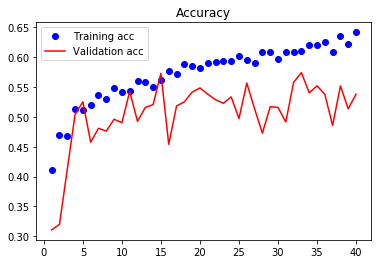

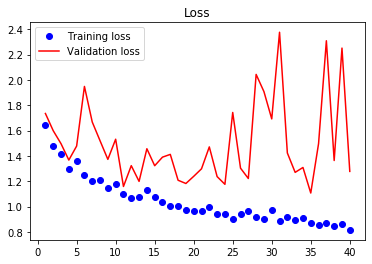

In [17]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(1, len(acc) + 1)
 
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Accuracy')
plt.legend()
plt.figure()
 
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss')
plt.legend()
 
plt.show()

In [18]:
X_test=np.load('X_test.npy')
y_test=np.load('y_test.npy')

In [19]:
_loss, _acc, _auc, _precision, _recall, _f1score = additional_model.evaluate(X_val, y_val, batch_size=32)
print('loss: {:.3f}, accuracy: {:.3f}, auc: {:.3f}, precision: {:.3f}, recall: {:.3f}, f1score: {:.3f}'.format(_loss, _acc, _auc, _precision, _recall, _f1score))

859/859 [==============================] - 3s 3ms/step
loss: 1.277, accuracy: 0.538, auc: 0.838, precision: 0.584, recall: 0.527, f1score: nan


In [22]:
_loss, _acc, _auc, _precision, _recall, _f1score = additional_model.evaluate(X_test, y_test, batch_size=32)
print('loss: {:.3f}, accuracy: {:.3f}, auc: {:.3f}, precision: {:.3f}, recall: {:.3f}, f1score: {:.3f}'.format(_loss, _acc, _auc, _precision, _recall, _f1score))

704/704 [==============================] - 29s 42ms/step
loss: 5201176.977, accuracy: 0.214, auc: 0.837, precision: 0.583, recall: 0.527, f1score: nan


In [24]:
additional_model.save('ResNet50_1.h5')